In [1]:
from src.optimization_model.lp_model import OliveHarvestModel, OliveHarvestModel_ServiceLevel
from src.optimization_model.model_data import OliveHarvestData, OliveHarvestDataFromJSON
import matplotlib.pyplot as plt

In [2]:
from src.optimization_model.utils import * 

In [3]:
GET_DATA_WEATHER = False
TRAIN_MODEL = False
CREATE_SCENARIOS = True

# get_data weather 
if GET_DATA_WEATHER:
    pass  # code to get weather data

# train the diffusion model to generate weather scenarios
if TRAIN_MODEL:
    pass  # code to train the model
if CREATE_SCENARIOS:
    pass

# generate weather scenarios

# get mean and std for uncertain parameters 
json_path = "src/optimization_model/params_model.json"


In [4]:
data = OliveHarvestDataFromJSON(json_path=json_path, alpha=0.99)

# mu, sigma get_from_yield_data(data)

mu = [0.8 * mu_j for mu_j in data.G.values()] 
sigma = [0.1 * mu_j for mu_j in mu]  # example: 10% std dev

In [5]:
count = 0
for i in data.S.keys():
    count = data.S[i] + count 
count 


576.4599999999999

In [6]:
model = OliveHarvestModel_ServiceLevel(data, sigma=sigma, mu=mu)
status = model.solve(msg=True)
print("Status:", status)
print("Objective (oil):", model.objective_value())
print("ReqBudget:", model.required_budget_value())
print("Nonzero x:", len(model.get_x()))
    

Status: Optimal
Objective (oil): 726.7216794822881
ReqBudget: 139727.3080581025
Nonzero x: 174


In [7]:
data.PD[2][1]

180.0

In [8]:
@staticmethod
def z_value(alpha: float) -> float:
    return norm_ppf(alpha)

In [9]:

def run_sweep_and_plot(
    json_path: str,
    sigma, 
    mu,
    alphas=(0.95, 0.975, 0.99),
    msg=False
):
    records = []  # list of dicts: alpha, oil, budget, status

    for a in alphas:
        data = OliveHarvestDataFromJSON(json_path=json_path, alpha=float(a))
        model = OliveHarvestModel_ServiceLevel(data, mu, sigma)

        status = model.solve(msg=msg)
        oil = model.objective_value()
        bud = model.required_budget_value()

        records.append({
            "alpha": float(a),
            "status": status,
            "oil": float(oil) if oil is not None else None,
            "budget": float(bud) if bud is not None else None,
        })

    # Filter feasible/optimal solves for plotting
    good = [r for r in records if r["oil"] is not None and r["budget"] is not None]

    if not good:
        print("No feasible solutions to plot. Statuses:")
        for r in records:
            print(r["alpha"], r["status"])
        return records

    al = [r["alpha"] for r in good]
    oil = [r["oil"] for r in good]
    bud = [r["budget"] for r in good]

    # --- Plot 1: Oil vs Confidence ---
    plt.figure()
    plt.plot(al, oil, marker="o")
    plt.xlabel("Confidence level (alpha)")
    plt.ylabel("Objective: oil yield")
    plt.title("Oil yield vs confidence level")
    plt.grid(True)
    plt.show()

    # --- Plot 2: Budget vs Confidence ---
    plt.figure()
    plt.plot(al, bud, marker="o")
    plt.xlabel("Confidence level (alpha)")
    plt.ylabel("Required budget")
    plt.title("Required budget vs confidence level")
    plt.grid(True)
    plt.show()

    # --- Plot 3: Oil vs Budget (trade-off) ---
    plt.figure()
    plt.scatter(bud, oil)
    plt.xlabel("Required budget")
    plt.ylabel("Objective: oil yield")
    plt.title("Trade-off: oil yield vs required budget")

    # label each point with alpha
    for r in good:
        plt.annotate(
            f'{r["alpha"]:.3f}',
            (r["budget"], r["oil"]),
            textcoords="offset points",
            xytext=(6, 6),
            ha="left"
        )

    plt.grid(True)
    plt.show()

    # Print summary table
    print("alpha | status | oil | budget")
    for r in records:
        print(f'{r["alpha"]:.3f} | {r["status"]} | {r["oil"]} | {r["budget"]}')

    return records

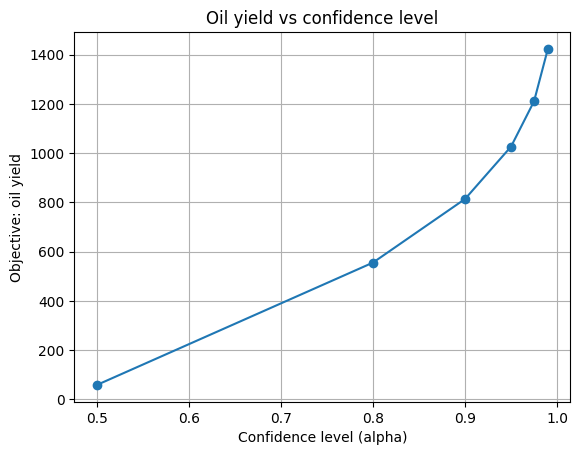

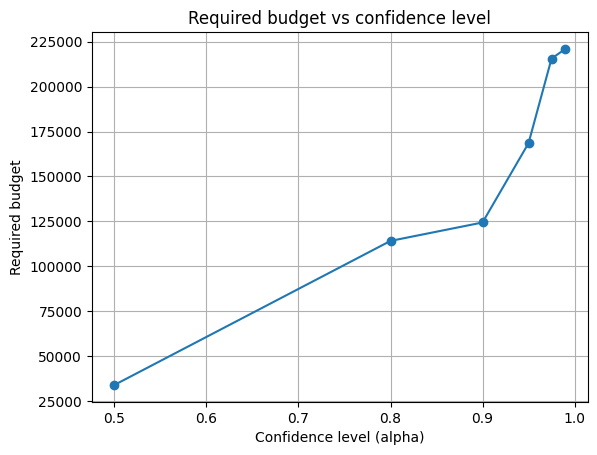

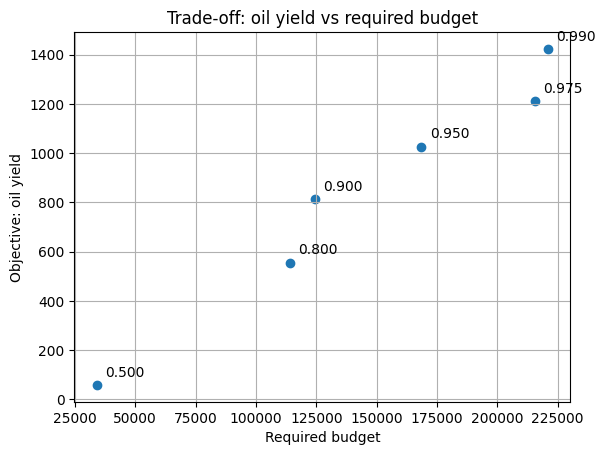

alpha | status | oil | budget
0.500 | Optimal | 58.5281076335419 | 34131.87459877524
0.800 | Optimal | 555.6289416608346 | 114192.69963044395
0.900 | Optimal | 814.0935225152565 | 124430.14699183057
0.950 | Optimal | 1026.9800732315782 | 168537.3323536669
0.975 | Optimal | 1211.1749869846926 | 215565.43422084991
0.990 | Optimal | 1423.8196755505164 | 220916.96965880305


In [10]:
records = run_sweep_and_plot(json_path, sigma, mu, alphas=[0.5, 0.80, 0.90, 0.95, 0.975, 0.99], msg=False)